# INIT

## Import and load the original data

In [1]:
import sys
sys.path.insert(1, '../') 
from utils.loader import Loader
from utils.data_processor import Data_processor
from utils.evaluator import Evaluator

from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, log_loss
from sklearn.metrics import make_scorer
import pandas as pd
from sklearn import tree
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import prince
import numpy as np

2024-11-17 16:53:43.875123: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731858823.892355  134040 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731858823.898264  134040 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-17 16:53:43.917490: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data = Loader.load_by_fueltype("Eléctrico")
label_encoder = LabelEncoder()
data["price_categ"].value_counts()

/home/liingfeng/Desktop/repos/Cars_Price_Prediction/Trees/../utils/loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
/home/liingfeng/Desktop/repos/Cars_Price_Prediction/Trees/../utils/loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
/home/liingfeng/Desktop/repos/Cars_Price_Prediction/Trees/../utils/loader.py:165: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on t

price_categ
Middle low range     1353
Luxury               1182
Premiun              1113
Middle range          820
High end              767
Middle high range     727
Budget                483
Low end               141
Very low end            5
Name: count, dtype: int64

### Describe some columns
A more detailed version of the dataset can be found in the DataDescription.ipynb

In [3]:
data.select_dtypes(include=['category'])

,color,brand,model,version,fuelType,bodyTypeId,transmissionTypeId,province,environmentalLabel,jato_classification,...,Acabado Exterior_Pintura,Acabado Exterior_Rueda,AC_Zones,AC_Type,Metodo_Apertura,Tipo_Faro,interior_clock,arm_suppport_front,arm_suppport_back,price_categ
idx,,,,,,,,,,,,,,,,,,,,,
118216,Verde,DACIA,Spring,Expression Electric 33kW 45CV,Eléctrico,Berlina,Automatico,Pontevedra,0,L1,...,pintura solida,rueda repuesto llanta acero menor tamaño resto,MONOZONA,STANDARD,Mando a distancia,Otro,no tiene,no tiene,no tiene,Middle low range
118241,Azul,VOLKSWAGEN,Golf,eGolf ePower 115CV,Eléctrico,Berlina,Automatico,Álava,0,M1,...,pintura solida,no tiene,BIZONA,AUTO,Mando a distancia,LED,no tiene,Tiene,Tiene,Budget
118337,Blanco,VOLKSWAGEN,Golf,eGolf ePower 100 kW 136CV,Eléctrico,Berlina,Automatico,Málaga,NaN,M1,...,pintura solida,no tiene,BIZONA,AUTO,Mando a distancia,LED,no tiene,Tiene,Tiene,Middle low range
118638,Verde,DACIA,Spring,Expression Electric 33kW 45CV,Eléctrico,Berlina,Automatico,Pontevedra,0,L1,...,pintura solida,rueda repuesto llanta acero menor tamaño resto,MONOZONA,STANDARD,Mando a distancia,Otro,no tiene,no tiene,no tiene,Middle low range
118656,Gris / Plata,FIAT,500,Icon Hb 320km 85kW 118CV,Eléctrico,Berlina,Automatico,Madrid,NaN,M2,...,pintura solida,no tiene,MONOZONA,AUTO,Tarjeta/llave inteligente,Otro,no tiene,no tiene,no tiene,Middle low range
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46869,Azul (Pintura metalizada),VOLKSWAGEN,Golf,eGolf ePower 100 kW 136CV,Eléctrico,Berlina,Automatico,Madrid,0,M1,...,pintura solida,no tiene,BIZONA,AUTO,Mando a distancia,LED,no tiene,Tiene,Tiene,Middle low range
46965,Blanco (Blanco Puro),VOLKSWAGEN,Golf,eGolf ePower 100 kW 136CV,Eléctrico,Berlina,Automatico,Madrid,0,M1,...,pintura solida,no tiene,BIZONA,AUTO,Mando a distancia,LED,no tiene,Tiene,Tiene,Middle low range
46966,Gris / Plata (Gris Indy (metalizado)),VOLKSWAGEN,Golf,eGolf ePower 100 kW 136CV,Eléctrico,Berlina,Automatico,Madrid,0,M1,...,pintura solida,no tiene,BIZONA,AUTO,Mando a distancia,LED,no tiene,Tiene,Tiene,Middle low range


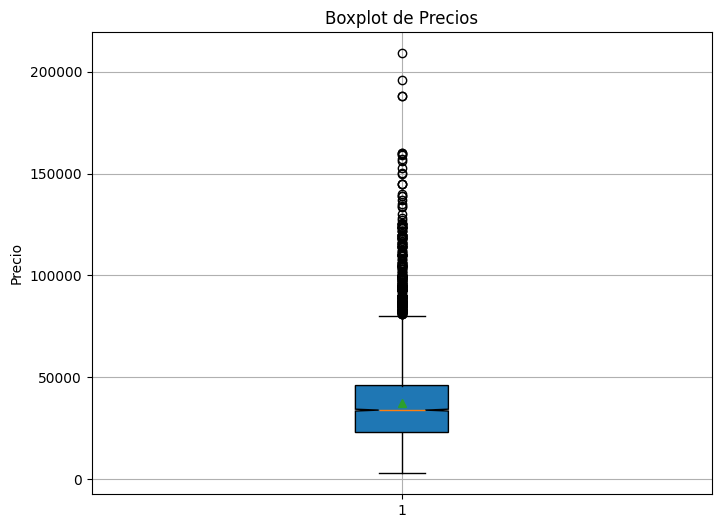

In [4]:
precios_electricos = data["price"]
plt.figure(figsize=(8, 6))
plt.boxplot(precios_electricos, notch=True, vert=True, patch_artist=True, showmeans=True)
plt.title('Boxplot de Precios')
plt.ylabel('Precio')
plt.grid(True)
plt.show()

The related outliers were checked manually throught the data source, and we could confirmed that they are not outliers

In [5]:
Q1 = data['price'].quantile(0.25)
Q2 = data['price'].quantile(0.5)  # Esta es la mediana
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1

upper_whisker = (Q3 + 1.5 * IQR)
print(upper_whisker)

data[data["fuelType"] == "Eléctrico"][data["price"]>upper_whisker][["price", "brand"]].sort_values(by='price', ascending=False)

80525.0


,price,brand
idx,,
28269,209000,MASERATI
85726,196000,MASERATI
144182,188000,MERCEDES-BENZ
134773,188000,MERCEDES-BENZ
21981,159900,PORSCHE
...,...,...
1917,81400,MERCEDES-BENZ
28058,80900,AUDI
43135,80900,LEXUS


# Electric cars

## Numerical variables selection Eléctrico
Here we will perform PCA and use correlation matrix to select the most correlated numerical variables

In [6]:
def fill_electric_numerical_columns(numerical_columns: pd.DataFrame) -> pd.DataFrame:
    #fill the elemental columns that has a minor amount of missing data with the mode
    numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, "dimensions.length")
    numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, "dimensions.height")
    numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, "electricFeatures.maximumBatteryKWH_kWh")
    numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, "electricFeatures.onboardCharger_kW")
    numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, "electricFeatures.range_KM")

    #fill the missing data witch regression, the parameters were based on the relation matrix 
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height"], y_column="dimensions.width")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height", "dimensions.width"], y_column="trunkCapacityInLiters")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw"], y_column="maxSpeed")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["Llantas_Diametro_cm", "power_kw"], y_column="max_torque_nm")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["electricFeatures.maximumBatteryKWH_kWh", "power_kw", "dimensions.length", "dimensions.height", "dimensions.width"], y_column="electricFeatures.combinedConsumption_kWh/")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["electricFeatures.maximumBatteryKWH_kWh", "electricFeatures.combinedConsumption_kWh/", "power_kw"], y_column="electricFeatures.range_KM")
    numerical_columns.dropna(axis=1, inplace=True)
    return numerical_columns

def get_electric_numerical_columns (data: pd.DataFrame) -> pd.DataFrame:
    numerical_columns = data.select_dtypes(include=['number'])
    numerical_columns.drop(columns=[ "car_id", "electricFeatures.maxPower_CV"], inplace=True) # electricFeatures.maxPower_CV is = power_cv (Duplicated colums)

    #if all the values of the numerical columns is 0, we remove the column
    cols_to_drop = numerical_columns.columns[(numerical_columns == 0).all()]
    numerical_columns = numerical_columns.drop(cols_to_drop, axis=1)

    #Remove the column with all NAs
    max_nans = 6586
    thresh = numerical_columns.shape[0] - max_nans

    numerical_columns.dropna(axis=1, thresh=thresh+1, inplace=True)
    return fill_electric_numerical_columns(numerical_columns)

In [7]:
numerical_columns = get_electric_numerical_columns(data)

Regression mape ['dimensions.length', 'dimensions.height'] -> dimensions.width: 1.6468475373043991%
Regression mape ['dimensions.length', 'dimensions.height', 'dimensions.width'] -> trunkCapacityInLiters: 16.915082042969487%
Regression mape ['power_cv', 'power_kw'] -> maxSpeed: 5.68947357102893%
Regression mape ['power_cv', 'power_kw', 'maxSpeed'] -> acceleration: 13.035625391285716%
Regression mape ['power_cv', 'power_kw', 'maxSpeed'] -> acceleration: 11.85488371952157%
Regression mape ['Llantas_Diametro_cm', 'power_kw'] -> max_torque_nm: 17.854083487783605%
Regression mape ['electricFeatures.maximumBatteryKWH_kWh', 'power_kw', 'dimensions.length', 'dimensions.height', 'dimensions.width'] -> electricFeatures.combinedConsumption_kWh/: 17.20475510968712%
Regression mape ['electricFeatures.maximumBatteryKWH_kWh', 'electricFeatures.combinedConsumption_kWh/', 'power_kw'] -> electricFeatures.range_KM: 16.161382226819622%


In [8]:
correlation_matrix = numerical_columns.corr()["price"]
print(correlation_matrix)

price                                        1.000000
km                                          -0.343331
year                                         0.459700
doors                                        0.092279
seatingCapacity                              0.257532
trunkCapacityInLiters                        0.301739
maxSpeed                                     0.655830
acceleration                                -0.582307
power_cv                                     0.709338
power_kw                                     0.712126
max_torque_nm                                0.677488
speakers                                     0.294090
dimensions.width                             0.689372
dimensions.height                            0.055209
dimensions.length                            0.613427
Numero_Testigos                              0.183137
Llantas_Diametro_cm                          0.633856
electricFeatures.range_KM                    0.600411
electricFeatures.maximumBatt

In [9]:
scaler = StandardScaler()
df_scaled  = scaler.fit_transform(numerical_columns)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

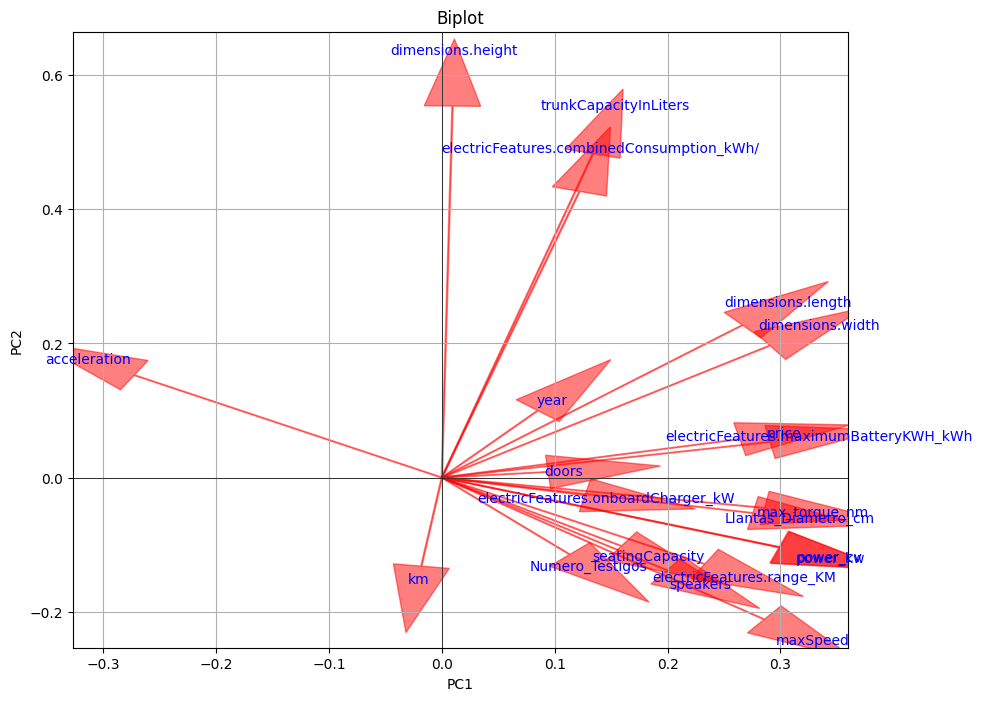

In [10]:
def biplot(score, coeff, labels=None):
    plt.figure(figsize=(10, 8))
    origin = [0, 0]  # Origen de las flechas

    # Dibujar las flechas
    for i in range(len(coeff)):
        plt.arrow(origin[0], origin[1], coeff[i,0], coeff[i,1], color='r', alpha=0.5, head_width=0.05, head_length=0.1)
        if labels is not None:
            plt.text(coeff[i,0]*1.15, coeff[i,1]*1.15, labels[i], color='blue', ha='center', va='center')

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Biplot")
    plt.grid(True)
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.xlim(min(coeff[:,0])*1.2, max(coeff[:,0])*1.2)
    plt.ylim(min(coeff[:,1])*1.2, max(coeff[:,1])*1.2)
    plt.show()

# Llamada a la función biplot
biplot(principal_components, np.transpose(pca.components_[0:2, :]), labels=numerical_columns.columns)

In [11]:
numerical_columns.drop(columns=["Numero_Testigos", "dimensions.height", "doors", "electricFeatures.onboardCharger_kW", "seatingCapacity"], inplace=True)

## Test CART regression trees with only numerical variables

In [12]:
X = numerical_columns.drop(columns="price")
y = numerical_columns["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

MAE: 3613.3816415321285 
 MSE: 45137212.88704389 
 RMSE: 6718.423392957897 
 R2: 0.8948865644471413 
 MAPE: 10.214356316913118
Mean: 3613.3816415321285
Variance: 32080685.999682475
Standard Deviation: 5663.981461806039


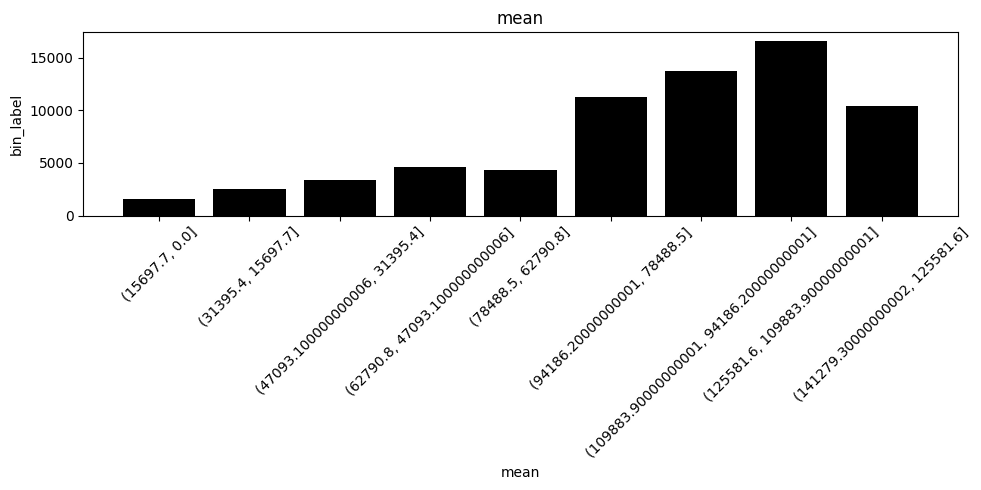

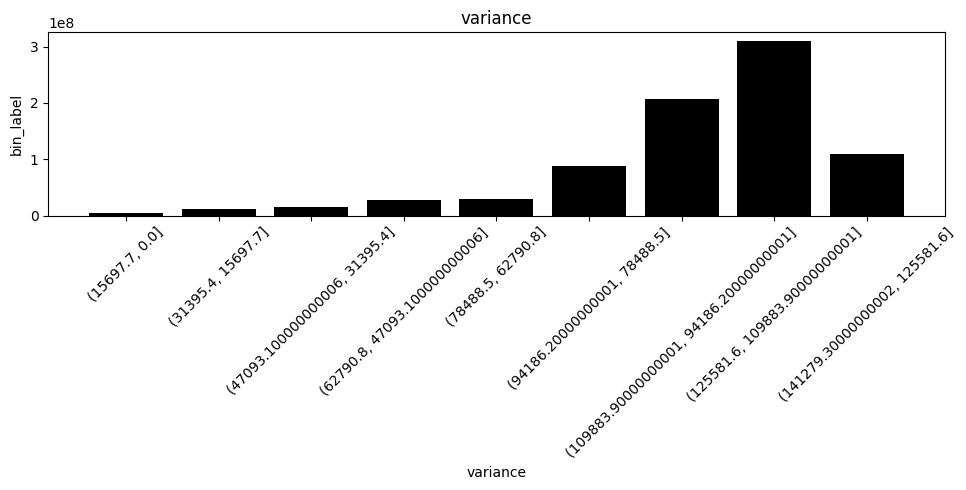

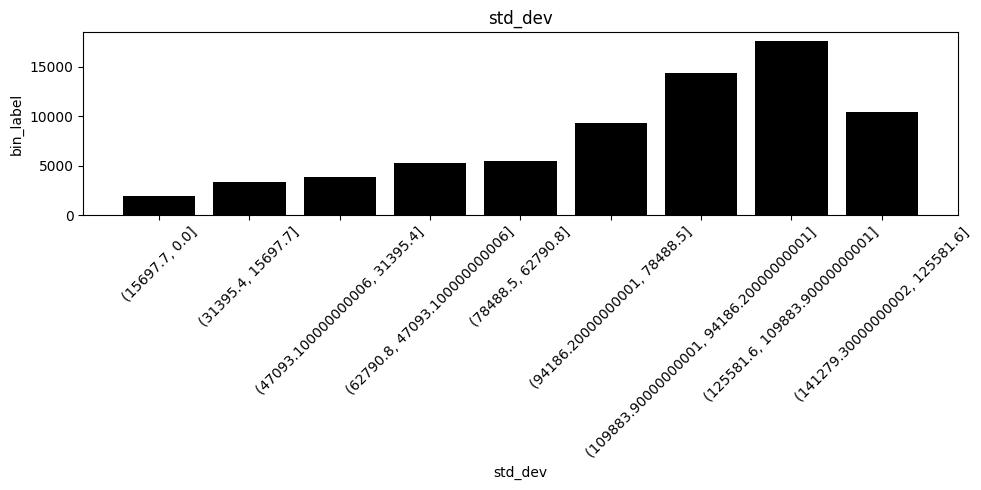

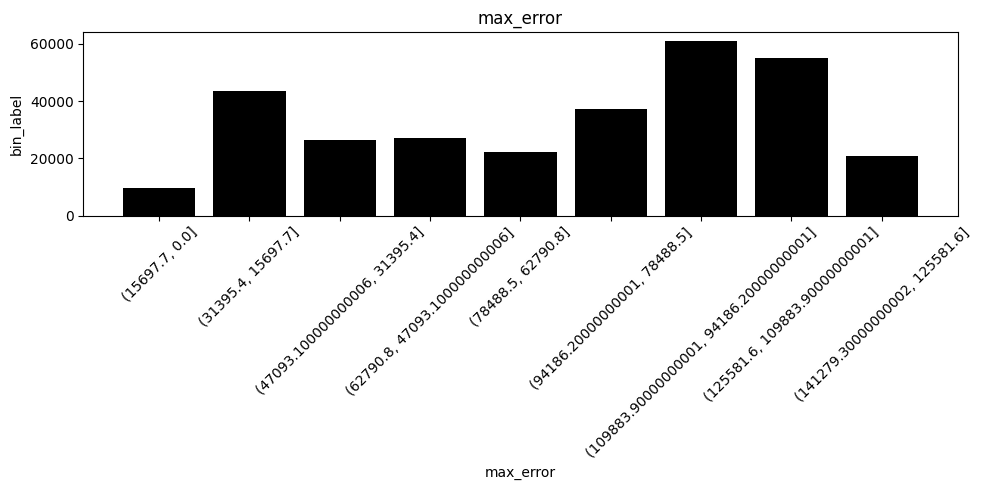

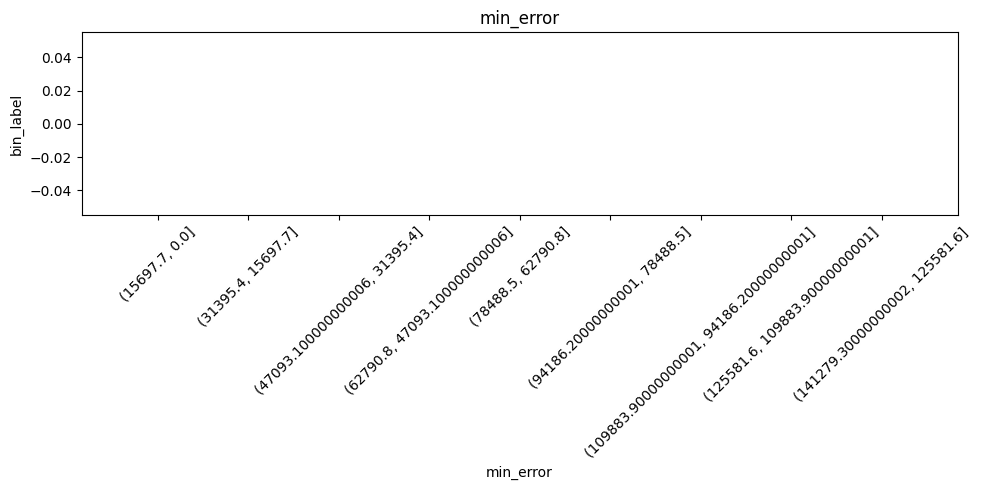

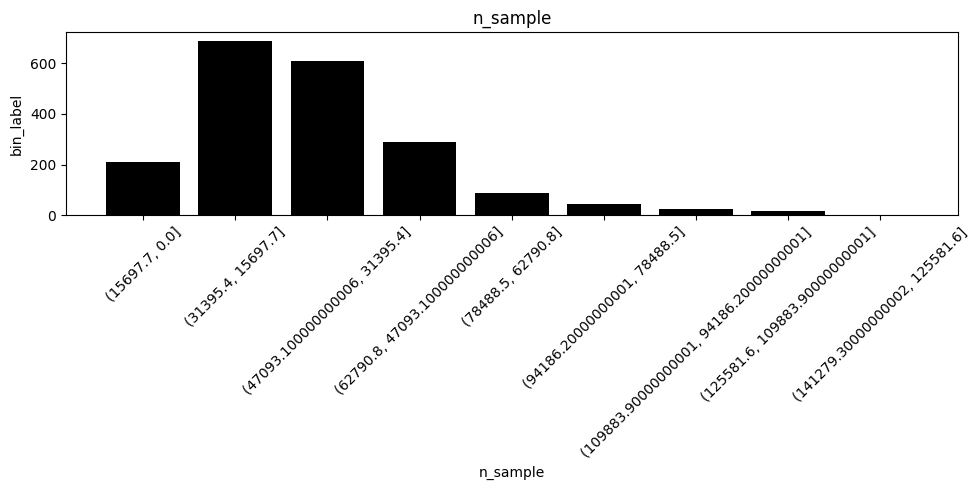

,bin_label,mean,variance,std_dev,max_error,min_error,n_sample
0,"(15697.7, 0.0]",1611.199052,3.703601e+06,1924.474282,9590.0,0.0,211
1,"(31395.4, 15697.7]",2523.741076,1.153781e+07,3396.735686,43503.0,0.0,687
2,"(47093.100000000006, 31395.4]",3365.398774,1.478719e+07,3845.411565,26291.0,0.0,608
3,"(62790.8, 47093.100000000006]",4601.839368,2.827787e+07,5317.693949,27090.0,0.0,289
4,"(78488.5, 62790.8]",4350.980875,3.020896e+07,5496.267635,22101.0,0.0,90
5,"(94186.20000000001, 78488.5]",11221.942208,8.748014e+07,9353.081923,37090.0,0.0,44
6,"(109883.90000000001, 94186.20000000001]",13730.333333,2.074539e+08,14403.259983,61100.0,0.0,24
7,"(125581.6, 109883.90000000001]",16580.157895,3.097482e+08,17599.664719,55110.0,0.0,19
8,"(141279.30000000002, 125581.6]",10450.000000,1.092025e+08,10450.000000,20900.0,0.0,2


In [13]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Realizar predicciones sobre el conjunto de prueba
y_pred = tree_model.predict(X_test)

Evaluator.eval_regression(y_pred, y_test, plot= True, bins=10)

## Electrico categorical variables
Here we will perform CA and Chi2 test to select the best categorical variables

In [14]:
def get_electric_categorical_columns(df: pd.DataFrame) -> pd.DataFrame:
    ret = df.select_dtypes(include=['category'])
    ret = ret.drop(columns=["environmentalLabel"]) #All of the cars of this dataframes are electrical which implies 0 emission
    ret = Data_processor.remove_redundand_columns(ret)
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model"], Y="version")
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model"], Y="jato_classification")
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model", "traction"], Y="brakes")
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model", "traction","brakes"], Y="front_suspension")
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model", "traction","brakes"], Y="rear_suspension")
    return ret

In [15]:
categorical_columns = get_electric_categorical_columns(data)
print("\nCategorical Columns Index:")
print(categorical_columns.index)


Categorical Columns Index:
Index([118216, 118241, 118337, 118638, 118656, 118657, 118659, 118665, 118675,
       118704,
       ...
        46372,  46386,  46402,  46455,  46580,  46869,  46965,  46966,  46988,
        47192],
      dtype='int64', name='idx', length=6591)


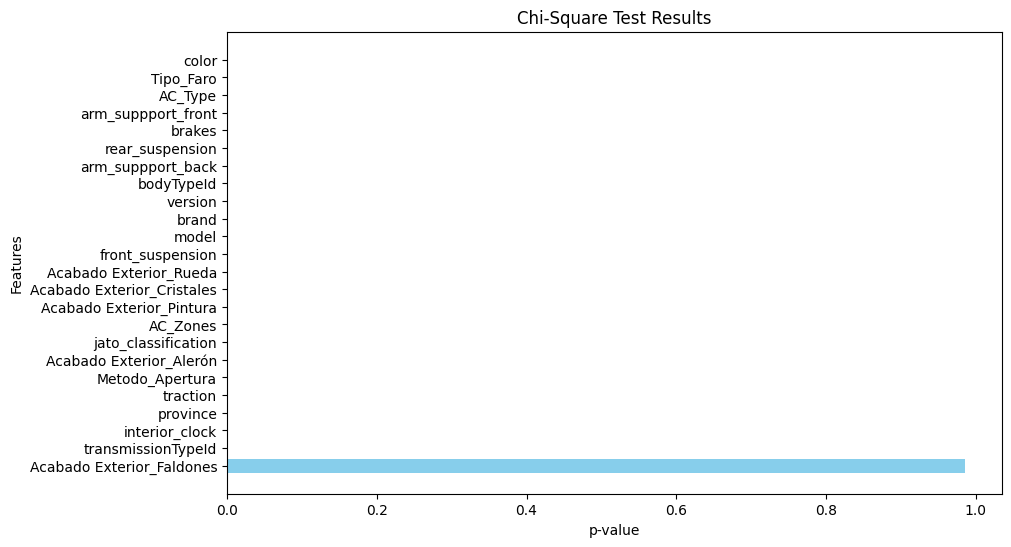

,Feature,Chi2 Stat,p-value
0,color,17355.917738,0.000000e+00
20,Tipo_Faro,1590.069687,0.000000e+00
18,AC_Type,1486.737498,0.000000e+00
22,arm_suppport_front,3759.181818,0.000000e+00
9,brakes,1581.335781,0.000000e+00
11,rear_suspension,1848.387572,0.000000e+00
23,arm_suppport_back,2401.453330,0.000000e+00
4,bodyTypeId,6530.816750,0.000000e+00
3,version,19903.204434,0.000000e+00
1,brand,1800.198086,0.000000e+00


In [16]:
Data_processor.chi_square_test(categorical_columns=categorical_columns, column_y="price_categ")

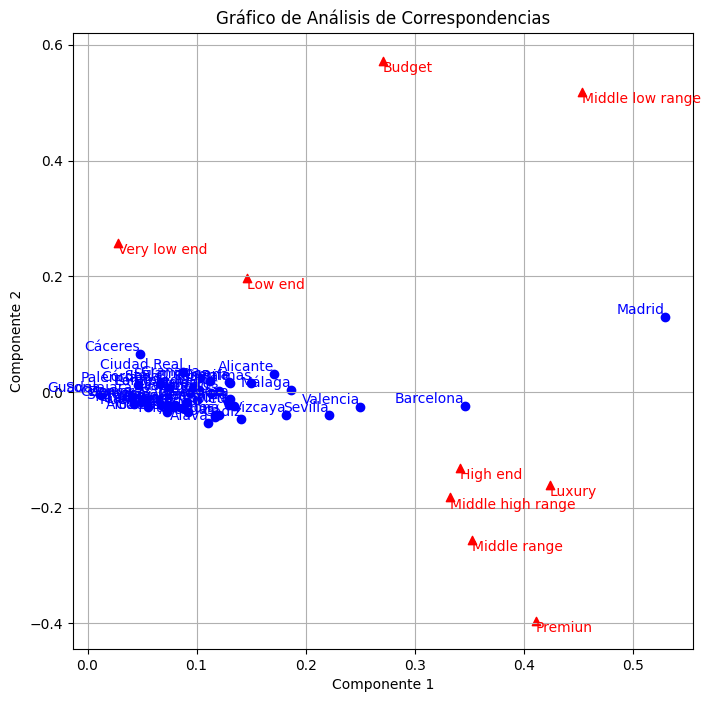

In [17]:
Data_processor.CA(categorical_columns=categorical_columns, col_x="province", col_y="price_categ")

In [18]:
categorical_columns["price_categ"].value_counts()

price_categ
Middle low range     1353
Luxury               1182
Premiun              1113
Middle range          820
High end              767
Middle high range     727
Budget                483
Low end               141
Very low end            5
Name: count, dtype: int64

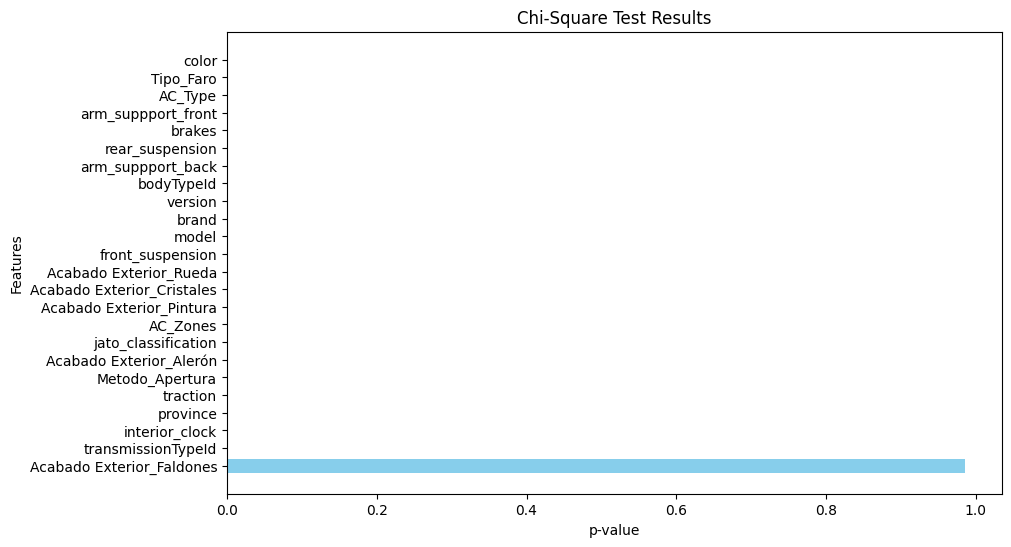

Index(['color', 'Tipo_Faro', 'AC_Type', 'arm_suppport_front', 'brakes',
       'rear_suspension', 'arm_suppport_back', 'bodyTypeId', 'version',
       'brand', 'model', 'price_categ'],
      dtype='object')

In [19]:
categorical_columns = Data_processor.chi_square_filter(categorical_columns, "price_categ", p_value_filter=0)
categorical_columns.columns

## Test CART tree classifier with only categorical values

In [20]:
features_df = pd.get_dummies(categorical_columns.drop('price_categ', axis=1))

# Your target variable
target = categorical_columns['price_categ'].apply(Loader.encode_price_categ)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_df, target, test_size=0.3, random_state=42)

# Initialize and train the Decision Tree Classifier
cart_model = DecisionTreeClassifier(random_state=42)
cart_model.fit(X_train, y_train)

# Predicting the test set results
y_pred = cart_model.predict(X_test)


In [21]:
result = pd.DataFrame({"Real_Categorie": y_test, "Prediction": y_pred})
result["diff"] = np.abs(result["Real_Categorie"].astype(int) - result["Prediction"])
result["Real_Categorie"] = result["Real_Categorie"].apply(Loader.decode_price_categ)
result["Prediction"] = result["Prediction"].apply(Loader.decode_price_categ)
result

,Real_Categorie,Prediction,diff
idx,,,
110061,Budget,Budget,0
34731,Middle range,Middle range,0
58032,Budget,Middle low range,1
7755,Premiun,Premiun,0
152527,Middle low range,Budget,1
...,...,...,...
151606,Middle high range,Budget,2
134374,High end,High end,0
20786,Luxury,Luxury,0


In [22]:
# Calcular la precisión
Evaluator.eval_classfication(y_pred=result["Prediction"].to_numpy(), y_true=result["Real_Categorie"].to_numpy(), binary_classification=False)

Accuracy: 0.6238624873609707 
 Precision: 0.6281314029814095 
 Recall: 0.6238624873609707 
 F1 Score: 0.6239559047767533
Confusion Matrix:
 [[315   2   0   0  13  41  43   1   0]
 [  3 105   0  10  30   0  25  53   0]
 [  0   0  28   0   0  12   1   0   1]
 [  0   8   0 271  11   0   1  87   0]
 [ 20  34   0   2  80   1  53  13   0]
 [ 35   0  22   0   0  88   1   0   0]
 [ 64   9   0   1  41   2 131   1   0]
 [  2  46   0  38  12   0   4 216   0]
 [  0   0   1   0   0   0   0   0   0]]


We can verify that the prediction is not very accurate but we need to know how big is the error.

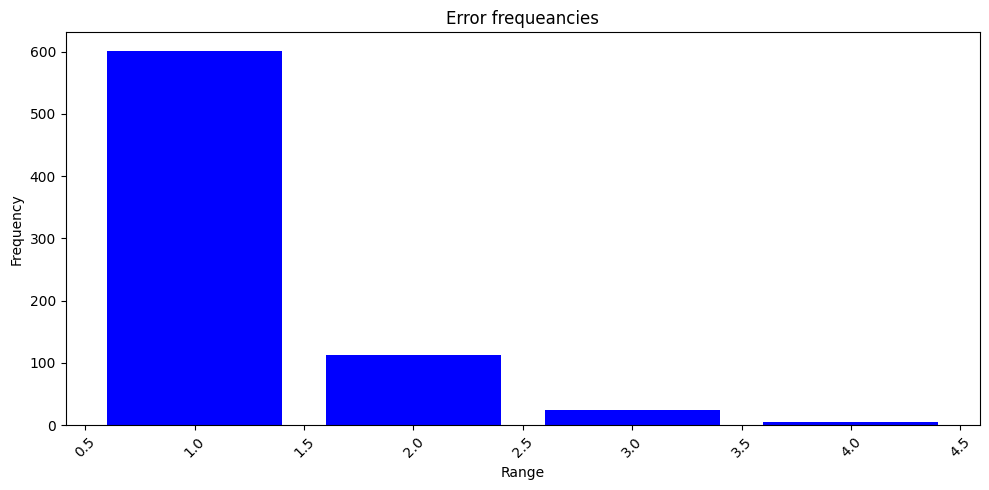

{1: 601, 2: 113, 3: 25, 4: 5}
Error mean: 1.239247311827957
Error rate: 37.613751263902934 %
Overall mean: 0.4661274014155713


In [23]:
Evaluator.eval_ordinal_classification (result["diff"])

Even having errors, we can verify that the errors are not that big

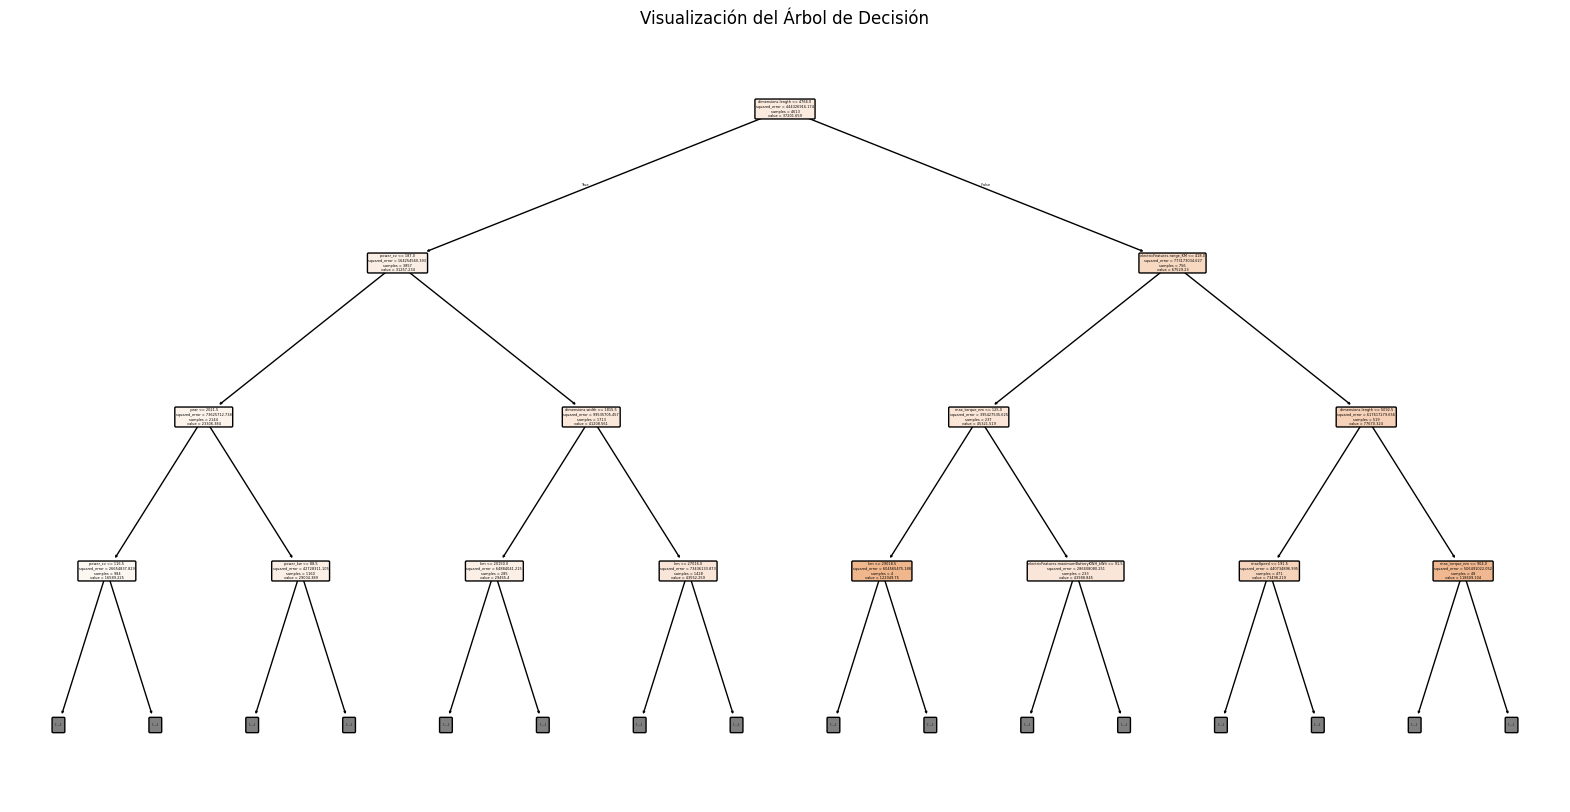

In [24]:
plt.figure(figsize=(20,10))

# Dibujar el árbol de decisión
plot_tree(tree_model, 
          filled=True, 
          rounded=True, 
          class_names=X_train.columns, 
          feature_names=X.columns, 
          max_depth=3)  # Puedes ajustar la profundidad para una mejor visualización o quitar este parámetro para mostrar todo el árbol
plt.title('Visualización del Árbol de Decisión')
plt.show()

# Agorithms evaluation

In [25]:
electric_cars = pd.merge(numerical_columns, categorical_columns, left_index=True, right_index=True, how='inner')
numerical_column_names = list(numerical_columns.columns)
categorical_column_names = list(categorical_columns.columns)
print(electric_cars.shape)
target = electric_cars[["price", "price_categ"]]
electric_cars.drop(columns=["price", "price_categ"], inplace=True)


numerical_column_names.remove("price")
categorical_column_names.remove("price_categ")

encoders_and_scalers = {}
for column in numerical_column_names:
    scaler = StandardScaler()
    electric_cars[[column]] = scaler.fit_transform(electric_cars[[column]])
    encoders_and_scalers[column] = scaler 

electric_cars_encoded = pd.get_dummies(electric_cars, columns=categorical_column_names)
print(electric_cars_encoded.shape)

(6591, 28)
(6591, 9182)


## Classification

In [26]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(electric_cars_encoded, target['price_categ'], test_size=0.3, random_state=42)

In [27]:
from sklearn.model_selection import cross_val_score


def eval_classification(y_test, y_pred):
    result = pd.DataFrame({"Real": y_test, "Prediction": y_pred})
    result["diff"] = result["Real"].apply(Loader.encode_price_categ).to_numpy() - result["Prediction"].apply(Loader.encode_price_categ).to_numpy()
    Evaluator.eval_ordinal_classification(diff=result["diff"])

def classify(X_train, X_test, y_train, y_test , classifier, classifier_name = None) -> None:
    classifier.fit(X_train, y_train)

    # Predicting the test set results
    y_pred = classifier.predict(X_test)
    eval_classification(y_test, y_pred)

    if classifier_name != None:
        Evaluator.eval_classfication(y_pred = y_pred, y_true=y_test, binary_classification=False, classifier_name=classifier_name)
    else:  Evaluator.eval_classfication(y_pred = y_pred, y_true=y_test, binary_classification=False)
    cv_scores = cross_val_score(classifier, X_test, y_test, cv=5, scoring='accuracy')
    Evaluator.plot_bar_chart_key_value(keys= [f"Fold {i+1}" for i in range(len(cv_scores))], values=cv_scores, title=f"Accuracy 5 folder Cross-validation", xlabel="fold", ylabel="accuracy")




### CART

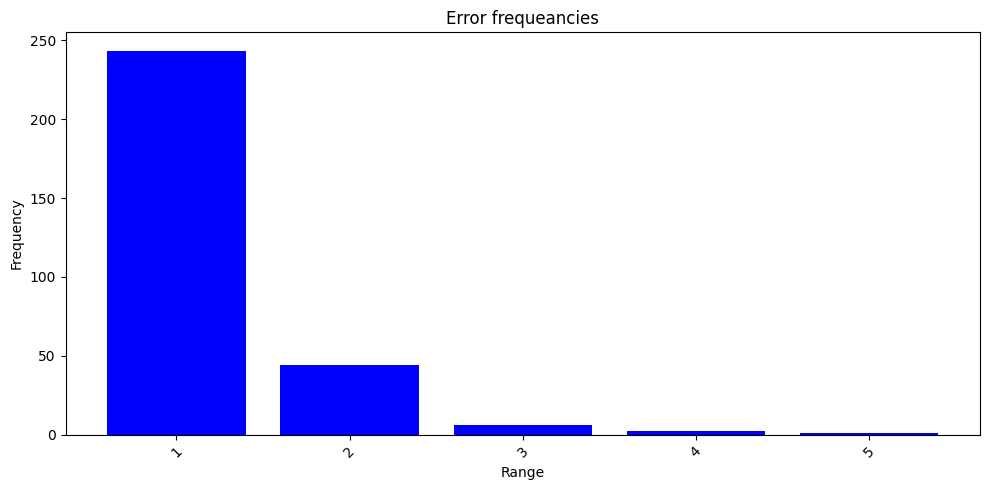

{1: 243, 2: 44, 3: 6, 4: 2, 5: 1}
Error mean: 1.222972972972973
Error rate: 14.964610717896864 %
Overall mean: 0.0020222446916076846
Accuracy: 0.6956521739130435 
 Precision: 0.6972233444656514 
 Recall: 0.6956521739130435 
 F1 Score: 0.6960283019691511
Confusion Matrix:
 [[110   0   9   0   0  26   0   0   1]
 [  0 130   1   6  29   2  10  48   0]
 [ 13   0  22   0   0   6   0   0   1]
 [  0   6   0 318   1   0   1  52   0]
 [  0  49   0   2  95  13  40   4   0]
 [ 17   4   2   0  12 334  46   0   0]
 [  1   9   1   0  43  47 147   1   0]
 [  0  48   0  36  11   1   2 220   0]
 [  1   0   0   0   0   0   0   0   0]]


/home/liingfeng/Desktop/tensorflow/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


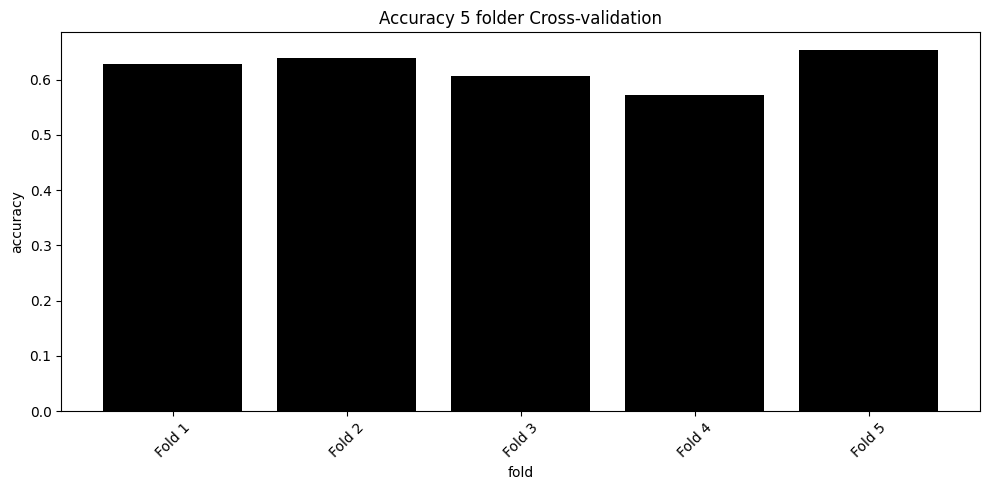

In [28]:
classify(X_train, X_test, y_train, y_test, DecisionTreeClassifier(random_state=42), classifier_name="CART")

### Random forest
Random forest can get a better result at a higher computational time cost

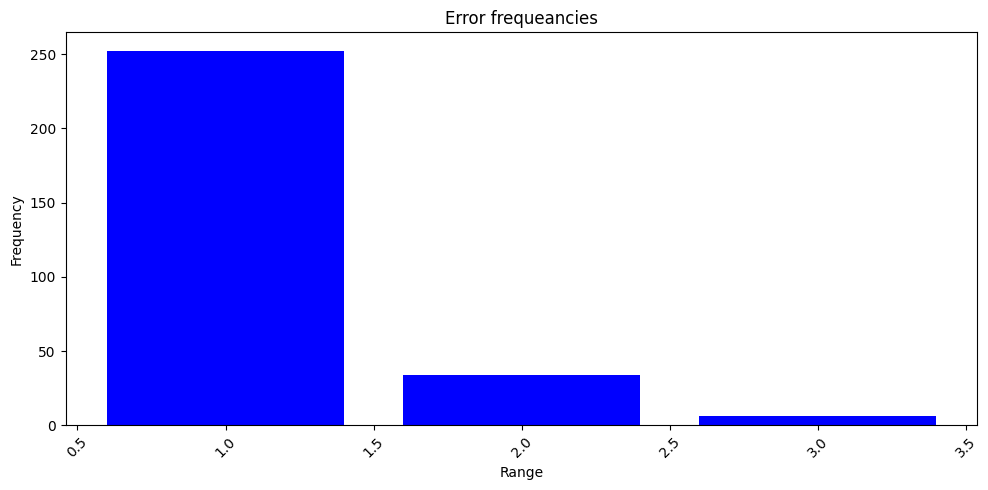

{1: 252, 2: 34, 3: 6}
Error mean: 1.1575342465753424
Error rate: 14.762386248736098 %
Overall mean: 0.012639029322548028
Accuracy: 0.7128412537917088 
 Precision: 0.7141616693402331 
 Recall: 0.7128412537917088 
 F1 Score: 0.7125466346398506
Confusion Matrix:
 [[105   0  11   0   0  30   0   0   0]
 [  0 128   0   2  29   1  15  51   0]
 [ 11   0  29   0   0   1   0   0   1]
 [  0   3   0 315   2   0   0  58   0]
 [  0  41   0   2  99  10  47   4   0]
 [ 16   2   0   0   9 345  43   0   0]
 [  0   7   0   1  39  51 150   1   0]
 [  0  39   0  31   6   0   3 239   0]
 [  1   0   0   0   0   0   0   0   0]]


/home/liingfeng/Desktop/tensorflow/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


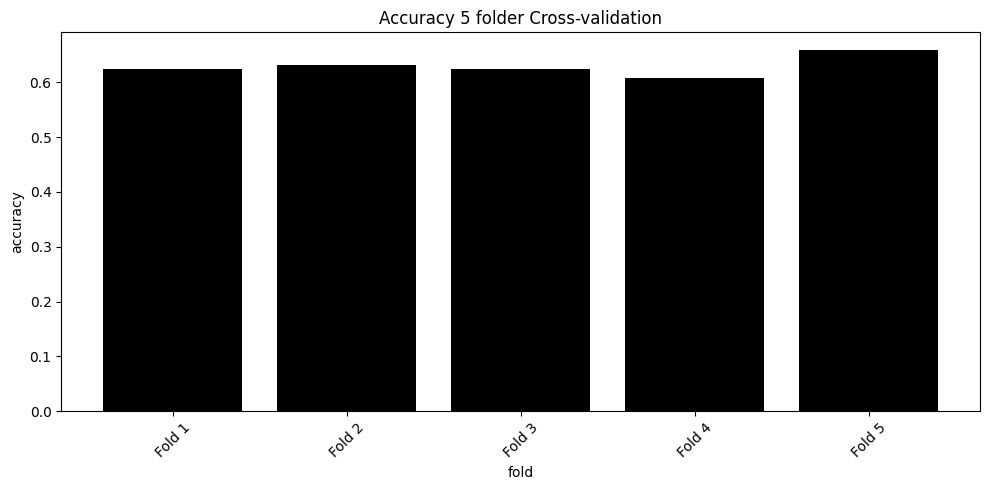

In [29]:
classify(X_train, X_test, y_train, y_test, RandomForestClassifier(random_state=42), classifier_name="RandomForestClassifier")

### SVM
Much higher computational cost, more distributed error, but in overall worse result

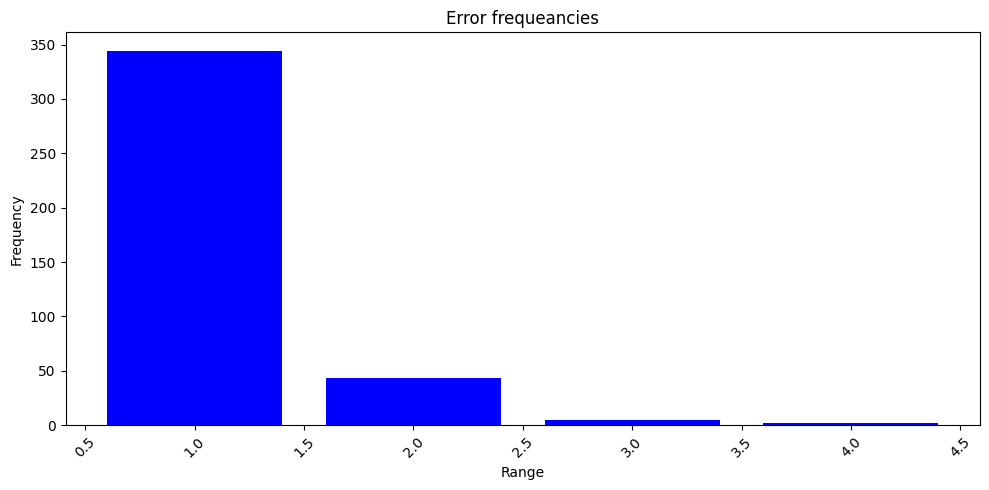

{1: 344, 2: 43, 3: 5, 4: 2}
Error mean: 1.149746192893401
Error rate: 19.919110212335692 %
Overall mean: 0.06572295247724974
Accuracy: 0.653690596562184 
 Precision: 0.666691138438481 
 Recall: 0.653690596562184 
 F1 Score: 0.6533000294626442
Confusion Matrix:
 [[108   0   9   0   0  29   0   0   0]
 [  0 109   0   1  30   1  23  62   0]
 [ 17   0  22   0   0   3   0   0   0]
 [  0   2   0 268   2   0   0 106   0]
 [  0  46   0   1  69   8  69  10   0]
 [ 31   1   0   0   3 326  54   0   0]
 [  1   7   0   1  38  56 146   0   0]
 [  0  43   0  17   9   2   2 245   0]
 [  1   0   0   0   0   0   0   0   0]]


/home/liingfeng/Desktop/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/liingfeng/Desktop/tensorflow/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


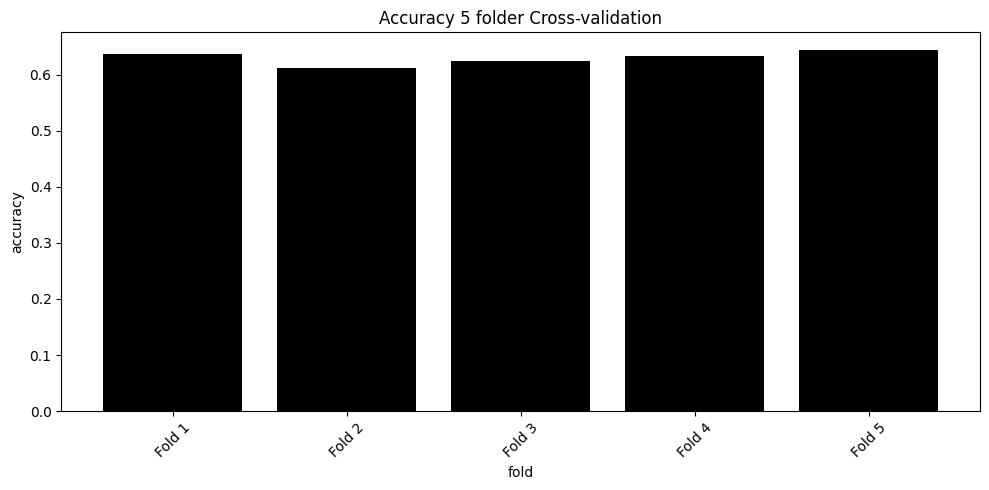

In [30]:
classify(X_train, X_test, y_train, y_test, SVC(random_state=42), classifier_name="SVC")

### Naive bayes

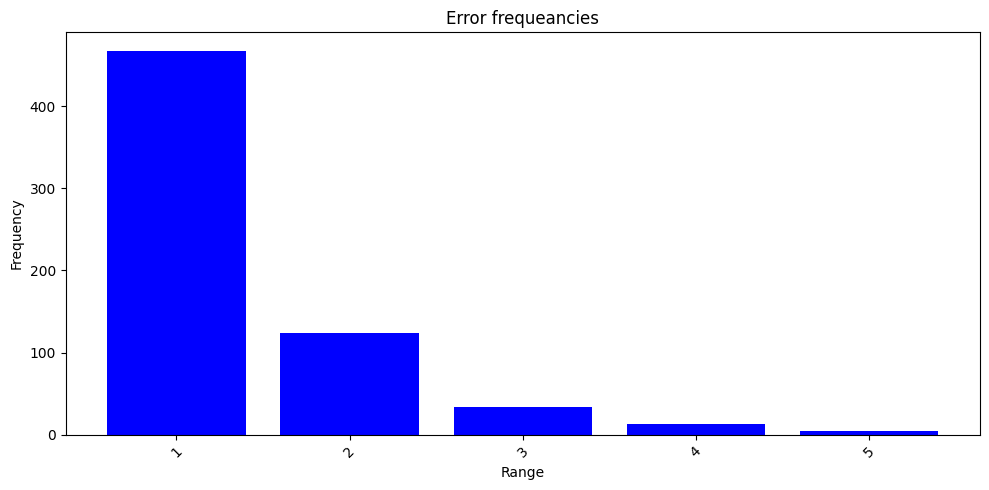

{1: 467, 2: 124, 3: 34, 4: 13, 5: 4}
Error mean: 1.384735202492212
Error rate: 32.45702730030334 %
Overall mean: 0.23104145601617795
Accuracy: 0.487360970677452 
 Precision: 0.5781191864332589 
 Recall: 0.487360970677452 
 F1 Score: 0.47019729956487055
Confusion Matrix:
 [[ 90   0  45   0   0   8   2   0   1]
 [  1  65   4  17  89   0  43   7   0]
 [  5   0  34   0   0   0   1   0   2]
 [  0   8   0 326  19   0   6  19   0]
 [  2  18   3   4  78   2  94   2   0]
 [117   4  20   0  20 113 141   0   0]
 [ 10   1   2   0  38  13 185   0   0]
 [  0  88   0 103  40   3  11  73   0]
 [  0   0   1   0   0   0   0   0   0]]


/home/liingfeng/Desktop/tensorflow/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


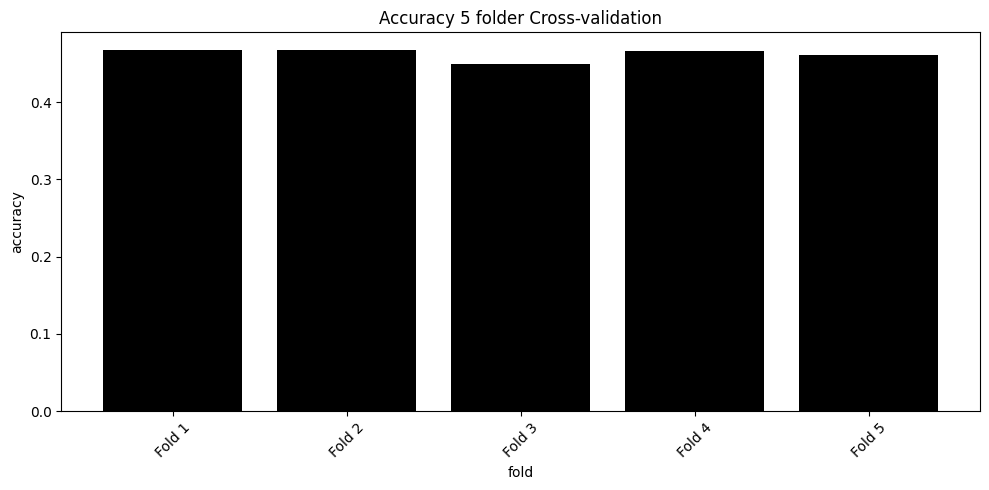

In [31]:
classify(X_train, X_test, y_train, y_test, GaussianNB(), classifier_name="Naive bayes")

### ANN

In [ ]:
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(target[['price_categ']])

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(
    electric_cars_encoded, y_encoded, test_size=0.3, random_state=42
)

# Step 3: Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 4: Define the ANN model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(y_train.shape[1], activation='softmax'))  # Softmax for multi-class classification

# Step 5: Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 6: Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128)

/home/liingfeng/Desktop/tensorflow/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1731858970.300406  134040 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7020 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:06:00.0, compute capability: 8.6


Epoch 1/100


I0000 00:00:1731858972.440794  134278 service.cc:148] XLA service 0x7d34e0010810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731858972.440816  134278 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-11-17 16:56:12.466271: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731858972.575026  134278 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-17 16:56:12.607809: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
2024-11-17 16:56:1

14/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1627 - loss: 3.8763

I0000 00:00:1731858979.390403  134278 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2381 - loss: 3.0411

2024-11-17 16:56:20.509032: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_256', 188 bytes spill stores, 188 bytes spill loads

2024-11-17 16:56:20.702474: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_256_0', 28 bytes spill stores, 28 bytes spill loads

2024-11-17 16:56:21.366273: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_270_0', 272 bytes spill stores, 272 bytes spill loads

2024-11-17 16:56:21.507831: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_284', 228 bytes spill stores, 248 bytes spill loads

2024-11-17 16:56:21.640438: I external/local_xla/xla/s

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.2412 - loss: 3.0159

2024-11-17 16:56:25.559936: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_53', 12 bytes spill stores, 12 bytes spill loads

2024-11-17 16:56:25.587280: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_53', 76 bytes spill stores, 76 bytes spill loads

2024-11-17 16:56:25.588039: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_53_0', 224 bytes spill stores, 224 bytes spill loads

2024-11-17 16:56:25.619055: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_53', 112 bytes spill stores, 112 bytes spill loads

2024-11-17 16:56:25.856845: I external/local_xla/xla/stream_ex

37/37 ━━━━━━━━━━━━━━━━━━━━ 18s 270ms/step - accuracy: 0.2442 - loss: 2.9920 - val_accuracy: 0.5506 - val_loss: 1.1595
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6155 - loss: 0.9461 - val_accuracy: 0.5844 - val_loss: 1.1338
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7183 - loss: 0.7117 - val_accuracy: 0.5966 - val_loss: 1.0772
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7186 - loss: 0.6747 - val_accuracy: 0.6355 - val_loss: 0.9887
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7677 - loss: 0.5417 - val_accuracy: 0.6370 - val_loss: 1.0576
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7592 - loss: 0.5716 - val_accuracy: 0.6446 - val_loss: 1.1252
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7907 - loss: 0.5047 - val_accuracy: 0.6593 - val_loss: 1.1179
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8012 - loss: 0.4818 - val_accuracy: 0.6476 - val

In [33]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

2024-11-17 16:57:20.104267: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_22', 268 bytes spill stores, 272 bytes spill loads

2024-11-17 16:57:20.260545: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_22', 16 bytes spill stores, 16 bytes spill loads

2024-11-17 16:57:20.420036: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_22_0', 108 bytes spill stores, 108 bytes spill loads

2024-11-17 16:57:20.495813: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_22', 416 bytes spill stores, 452 bytes spill loads

2024-11-17 16:57:20.852133: I external/local_xla/xla/stream_

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

2024-11-17 16:57:23.216524: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_22', 12 bytes spill stores, 12 bytes spill loads

2024-11-17 16:57:23.311521: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_22', 252 bytes spill stores, 252 bytes spill loads

2024-11-17 16:57:23.599651: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_22_0', 108 bytes spill stores, 108 bytes spill loads

2024-11-17 16:57:23.649363: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_29_0', 268 bytes spill stores, 268 bytes spill loads

2024-11-17 16:57:23.748555: I external/local_xla/xla/strea

62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step


In [34]:
Evaluator.eval_classfication(y_pred=y_pred_classes, y_true=y_test_classes, binary_classification=False, classifier_name="ANN")

Accuracy: 0.673407482305359 
 Precision: 0.6722703673370437 
 Recall: 0.673407482305359 
 F1 Score: 0.6719075161154103
Confusion Matrix:
 [[109   0  17   0   0  20   0   0   0]
 [  0 107   1   7  34   0  24  53   0]
 [ 10   0  28   0   0   1   2   0   1]
 [  0   1   0 329   1   0   0  47   0]
 [  1  35   0   5  86   8  61   7   0]
 [ 31   3   2   1  13 319  45   1   0]
 [  3   8   0   4  45  47 140   2   0]
 [  0  38   0  51  11   0   4 214   0]
 [  1   0   0   0   0   0   0   0   0]]


## Regression

In [35]:
X_train, X_test, y_train, y_test = train_test_split(electric_cars_encoded, target['price'], test_size=0.3, random_state=42)

In [ ]:
def regression(X_train, X_test, y_train, y_test , regressor, regressor_name = None) -> None:
    regressor.fit(X_train, y_train)

    # Predicting the test set results
    y_pred = regressor.predict(X_test)
    if regressor_name != None:
        Evaluator.eval_regression(y_pred = y_pred, y_true=y_test, plot=False, n_features=len(electric_cars_encoded.columns), regressor_name=regressor_name)
    else :Evaluator.eval_regression(y_pred = y_pred, y_true=y_test, plot=False)
    mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
    cv_scores = -cross_val_score(regressor, X_test, y_test, cv=5, scoring=mape_scorer)
    Evaluator.plot_bar_chart_key_value(keys= [f"Fold {i+1}" for i in range(len(cv_scores))], values=cv_scores, title=f"Accuracy 5 folder Cross-validation", xlabel="fold", ylabel="MAPE")

### Cart

MAE: 3559.785467523713 
 MSE: 44347014.99053612 
 RMSE: 6659.3554485803 
 R2: 0.8967267404428643 
 MAPE: 9.98205644745075
Mean: 3559.785467523713
Variance: 31674942.41574311
Standard Deviation: 5628.049610277357
r2_adjusted: 1.0283374370776486


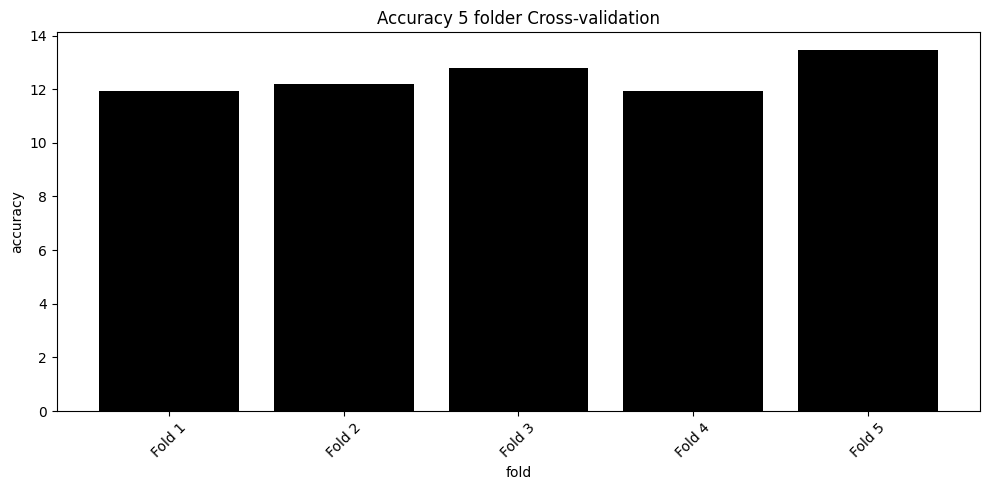

In [37]:
regression(X_train, X_test, y_train, y_test , DecisionTreeRegressor(random_state=42), regressor_name="CART")

### RandomForest

MAE: 2887.0472400919493 
 MSE: 23943348.420241736 
 RMSE: 4893.194091822001 
 R2: 0.9442418472450006 
 MAPE: 8.330409707627641
Mean: 2887.0472400919493
Variance: 15608306.65371919
Standard Deviation: 3950.7349510843155
r2_adjusted: 1.015299634697659


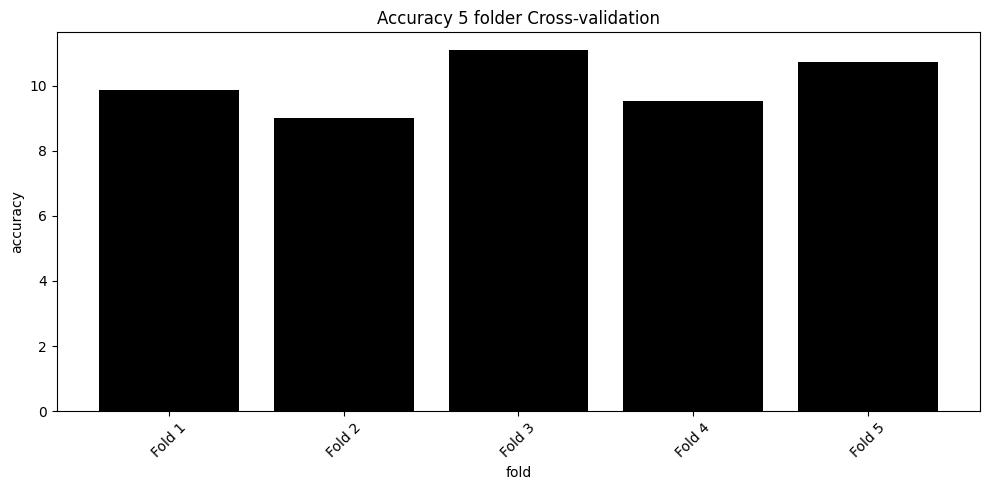

In [38]:
regression(X_train, X_test, y_train, y_test , RandomForestRegressor(random_state=42), regressor_name="RandomForest")

### SVM Regression

MAE: 14336.727291323832 
 MSE: 413056473.6443419 
 RMSE: 20323.790828591547 
 R2: 0.03809335479443876 
 MAPE: 48.70396637156693
Mean: 14336.727291323832
Variance: 207514724.21855226
Standard Deviation: 14405.371366908674
r2_adjusted: 1.2639402411618867


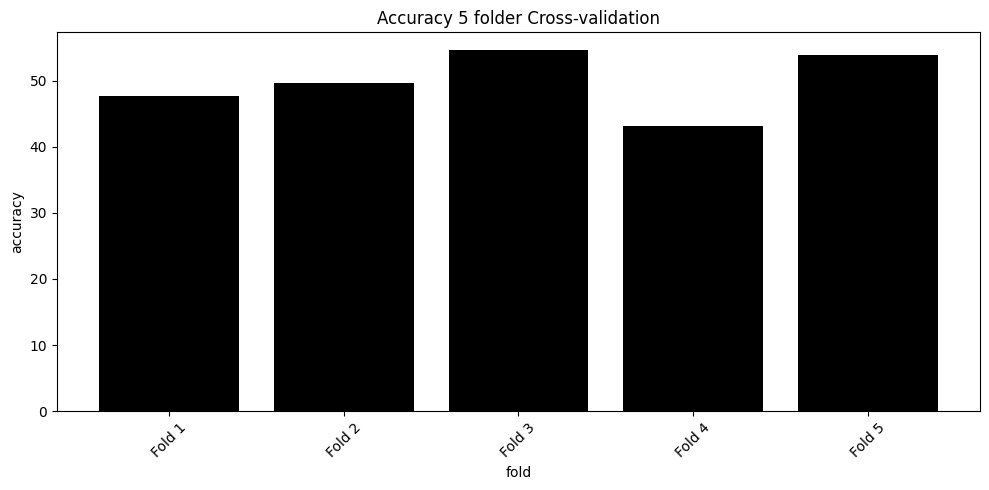

In [39]:
regression(X_train, X_test, y_train, y_test , SVR(kernel='sigmoid'), regressor_name="SVR")

### Multivariable regression

In [40]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

# Predicting the test set results
y_pred = linear_regressor.predict(X_test)

# Optionally, display the coefficients of the model
print("Coefficients:", linear_regressor.coef_)
print("Intercept:", linear_regressor.intercept_)

Coefficients: [-2.26827406e+03  4.92997613e+03 -3.25590279e+03 ... -3.09672735e+13
  8.87474245e+13 -2.01782791e+13]
Intercept: -27634188809601.19


In [41]:
result = pd.DataFrame({"Real": y_test, "Prediction": y_pred})
result["diff"] = result["Real"].to_numpy() - result["Prediction"].to_numpy()

MAE: 7602947532325.294 
 MSE: 2.3273674875870925e+27 
 RMSE: 48242797261219.13 
 R2: -5.419864824762472e+18 
 MAPE: 27033256875.90292
Mean: 7602947532325.294
Variance: 2.269562676407801e+27
Standard Deviation: 47639927334199.42
r2_adjusted: 1.4871717916107436e+18


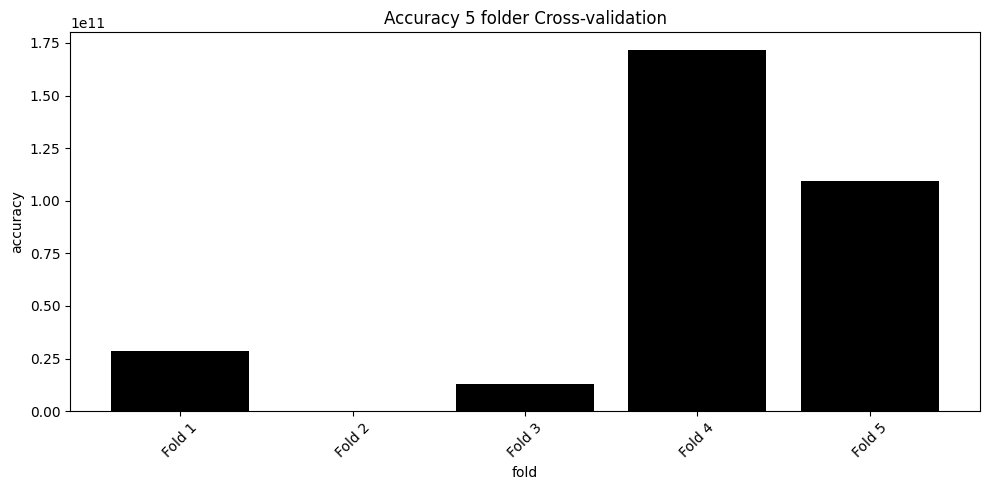

In [42]:
Evaluator.eval_regression(y_pred = y_pred, y_true=y_test, plot=False, n_features=len(electric_cars_encoded.columns), regressor_name="Lineal Regression")
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
cv_scores = -cross_val_score(linear_regressor, X_test, y_test, cv=5, scoring=mape_scorer)
Evaluator.plot_bar_chart_key_value(keys= [f"Fold {i+1}" for i in range(len(cv_scores))], values=cv_scores, title=f"Accuracy 5 folder Cross-validation", xlabel="fold", ylabel="accuracy")

In [43]:
result

,Real,Prediction,diff
idx,,,
110061,20900,2.603693e+04,-5.136934e+03
34731,26990,2.793456e+04,-9.445586e+02
58032,16900,-2.395405e+13,2.395405e+13
7755,41900,4.288356e+04,-9.835586e+02
152527,12990,1.106556e+04,1.924441e+03
...,...,...,...
151606,31400,2.673792e+04,4.662082e+03
134374,37380,-7.174888e+13,7.174888e+13
20786,55236,5.057925e+04,4.656754e+03


### ANN

In [52]:
# Define the model
model = Sequential()

model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='linear'))
model.add(Dense(1))


/home/liingfeng/Desktop/tensorflow/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [53]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [54]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128)


Epoch 1/100


2024-11-17 17:02:47.713217: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_201', 24 bytes spill stores, 24 bytes spill loads



37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1819338240.0000 - mae: 37112.5156

2024-11-17 17:02:50.935790: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30', 12 bytes spill stores, 12 bytes spill loads



37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 1819559424.0000 - mae: 37114.7031 - val_loss: 1804319104.0000 - val_mae: 37086.5977
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1827486848.0000 - mae: 36927.2422 - val_loss: 1719663872.0000 - val_mae: 36144.3906
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1662218624.0000 - mae: 35306.8438 - val_loss: 1027102272.0000 - val_mae: 27395.8398
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 720930560.0000 - mae: 21665.2344 - val_loss: 127582032.0000 - val_mae: 7734.1245
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 131917888.0000 - mae: 7571.5767 - val_loss: 94960456.0000 - val_mae: 6259.3540
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 96486608.0000 - mae: 6113.5586 - val_loss: 80850000.0000 - val_mae: 5836.0698
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 80184808.0000 - mae: 5524.5283 - val_loss: 70768200.0000 - val_mae: 5425.6270
Epoch 8/100
37/37 ━━━━━━━━━━━━

In [47]:
loss, mae = model.evaluate(X_test, y_test, verbose=2)
print(f"Mean Absolute Error on test set: {mae:.2f}")

2024-11-17 17:02:00.472796: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_62', 64 bytes spill stores, 64 bytes spill loads

2024-11-17 17:02:00.606677: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_62', 116 bytes spill stores, 116 bytes spill loads

2024-11-17 17:02:01.907793: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_62', 68 bytes spill stores, 68 bytes spill loads

2024-11-17 17:02:02.150992: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_62', 188 bytes spill stores, 188 bytes spill loads



62/62 - 3s - 47ms/step - loss: 35143612.0000 - mae: 3879.4004
Mean Absolute Error on test set: 3879.40


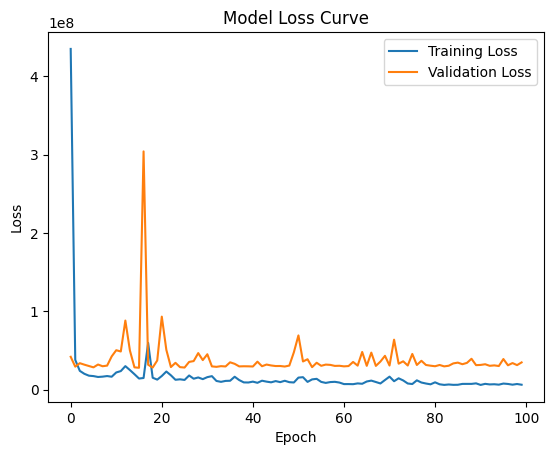

In [48]:
# Plot the loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss Curve')
plt.show()

In [49]:
y_pred = model.predict(X_test).flatten()

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [50]:
Evaluator.eval_regression(y_pred=y_pred, y_true=y_test, plot=False, n_features=len(electric_cars_encoded.columns), regressor_name="ANN")

MAE: 3879.3999240670814 
 MSE: 35143617.91061899 
 RMSE: 5928.205285802693 
 R2: 0.9181591868400574 
 MAPE: 10.849196434021717
Mean: 3879.3999240670814
Variance: 20093874.13976731
Standard Deviation: 4482.619116071241
r2_adjusted: 1.022456528468731


,bin_label,mean,variance,std_dev,max_error,min_error,n_sample
0,"(31395.4, 0.0]",2327.349724,4.718529e+06,2172.217477,18181.453125,0.093750,898
1,"(62790.8, 31395.4]",4316.426114,1.236205e+07,3515.970255,28819.453125,11.900391,897
2,"(94186.20000000001, 62790.8]",7857.344974,4.283549e+07,6544.882590,39759.859375,485.929688,134
3,"(125581.6, 94186.20000000001]",11050.762718,1.111206e+08,10541.375559,44352.898438,108.695312,43


In [51]:
Evaluator.save("electric_plug")

Regression results saved to: evaluation/electric_plug_regression.tex
Classification results saved to: evaluation/electric_plug_classification.tex
